## Shrink build_tables_output

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils

In [2]:
datadir = '/home/freddy/insight/data/'
filename = datadir + 'build_tables_output.csv'

In [3]:
df = pd.read_csv(filename)
nrows0 = df.shape[0]

/home/freddy/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df=df[df.terrain != 'Multi']

In [5]:
df=df.drop(columns=['Unnamed: 0'], axis=1)

In [6]:
cols = ['age_group','name','sex', 'race_title', 
        'terrain', 'race_date', 'meeting_id']

In [7]:
for i in cols:
    df = df[pd.notnull(df[i])]

In [8]:
# Make it huge b/c I will find min later
df['chip_time'].fillna('100:59:59', inplace=True)
df['gun_time'].fillna('100:59:59', inplace=True)

In [9]:
nrows1 = df.shape[0]
frac = (1-nrows1/nrows0)*100
print('percent lost = %1.3f%%' % frac)

percent lost = 27.459%


In [10]:
def cut_up_url(url):
    flag = 'meetingid='
    start = url.find(flag)+len(flag) 
    end   = url.find('&')
    substr = url[start:end]
    return int(substr)

In [11]:
def handle_gpx(filename):
    gpx = pd.read_csv(filename, header=0)
    gpx['meeting_id'] = gpx['URL'].apply(lambda x: cut_up_url(x))
    #gpx.rename(index=str, columns={'race_data':'race_date'})
    return gpx
#gpx = handle_gpx(datadir + 'gpx_discover.csv')
#gpx_IDs = gpx['meeting_id'].tolist()

In [12]:
def cleaned_gpx(filename):
    gpx = pd.read_csv(filename, header=0)
    return gpx

In [13]:
gpx = cleaned_gpx(datadir + 'gpx_elevation_map_new.csv')

In [14]:
# Make everything unique, and then find the overlap
IDs = df['meeting_id'].tolist()
gpx_IDs = gpx['meeting_id'].tolist()
uniqueIDs = set(IDs)
gpx_uniqueIDs = set(gpx_IDs)
overlapIDs = list(uniqueIDs & gpx_uniqueIDs)
print('Found %d GPX files with overlapping IDs' % len(overlapIDs))

Found 105 GPX files with overlapping IDs


## For now, only consider races that have a corresponding GPX file.

In [15]:
dfnew = df[df['meeting_id'].isin(overlapIDs)]
gpxnew = gpx[gpx['meeting_id'].isin(overlapIDs)]

In [16]:
dfnew.meeting_id = dfnew.meeting_id.astype(int)
dfnew.uniqueID = dfnew.uniqueID.astype(int)

/usr/lib/python3/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [17]:
def fix_time(t):
    parts = t.split(':')
    ncolons = t.count(':')
    if ncolons == 1:
        return t
    elif ncolons == 2:
        min = int(parts[0])*60 + int(parts[1])
        return str(min) + ':' + parts[2]
    else:
        return '10000:00'

In [18]:
# The chip/gun times are inconsistent
dfnew['chip_time_corr']=dfnew['chip_time'].apply(lambda x: fix_time(str(x)))
dfnew['gun_time_corr']=dfnew['gun_time'].apply(lambda x: fix_time(str(x)))

/home/freddy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/freddy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# Let's make a new column that takes the min of chip/gun,
# make it a float so we can plot later - units = minutes
def find_min_time(row):
    # There should be a gun-time for everyone, but chip time has been
    # set to something large
    chip = row['chip_time_corr'].split(':')
    gun = row['gun_time_corr'].split(':')
    # convert to seconds, compare immediately
    chiptime = int(chip[0])*60 + int(chip[1])
    guntime  = int(gun[0])*60 + int(gun[1])
    time = guntime if (guntime <= chiptime) else chiptime
    return float(time)/60.0

In [20]:
dfnew['min_time'] = dfnew.apply(find_min_time,axis=1)

/home/freddy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
#dfnew.to_csv('data_overlaps_with_gpx.csv',sep=',')

In [30]:
dfnew.loc[dfnew.race_title=='10k','race_title'] = '10K'
dfnew=dfnew[dfnew.race_title == '10K']
norm = 10.0 * 1.0
gpx_up = dict(zip(gpxnew.meeting_id, gpxnew.sum_up))
gpx_down = dict(zip(gpxnew.meeting_id, gpxnew.sum_down))
gpx_mean = dict(zip(gpxnew.meeting_id, gpxnew['mean']))
gpx_sigma = dict(zip(gpxnew.meeting_id, gpxnew.sigma))
dfnew['sum_up']=dfnew['meeting_id'].apply(lambda x:   gpx_up[x]/norm)
dfnew['sum_down']=dfnew['meeting_id'].apply(lambda x: gpx_down[x]/norm)
dfnew['mean']=dfnew['meeting_id'].apply(lambda x:     gpx_mean[x])
dfnew['sigma']=dfnew['meeting_id'].apply(lambda x:    gpx_sigma[x])

In [43]:
dfnew['diff'] = dfnew['sum_up'] - dfnew['sum_down']

In [31]:
dftemp = dfnew
#races = dftemp['race_location'].tolist()
#uniqueraces = set(races)

In [32]:
columns2drop = ['chip_time','gun_time','name','race_title',
                'terrain','race_date','race_location','uniqueID',
               'chip_time_corr','gun_time_corr']
dfnew = dfnew.drop(columns2drop, axis=1)

In [33]:
sigmas=dfnew.groupby(['meeting_id','mean','sigma'],as_index=False)['min_time'].mean()

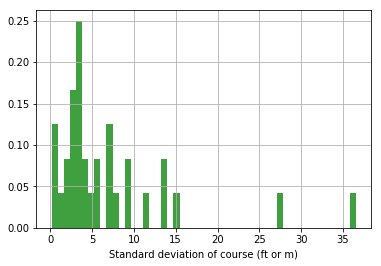

In [34]:
n, bins, patches = plt.hist(sigmas['sigma'], 50, density=True, 
                            facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Standard deviation of course (ft or m)')
plt.show()

[0, 40, 35, 70]

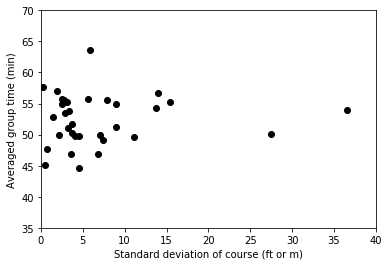

In [35]:
plt.scatter(sigmas['sigma'], sigmas['min_time'], 
            color='black')
plt.xlabel('Standard deviation of course (ft or m)')
plt.ylabel('Averaged group time (min)')
plt.axis([0, 40, 35, 70])

Text(0,0.5,'Averaged group time (min)')

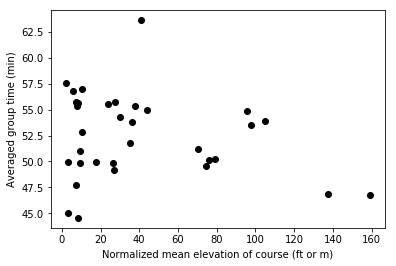

In [38]:
plt.scatter(sigmas['mean'], sigmas['min_time'], 
            color='black')
plt.xlabel('Normalized mean elevation of course (ft or m)')
plt.ylabel('Averaged group time (min)')

In [39]:
dftimes=dfnew.groupby(['meeting_id','age_group','sex'],as_index=False)['min_time'].mean()

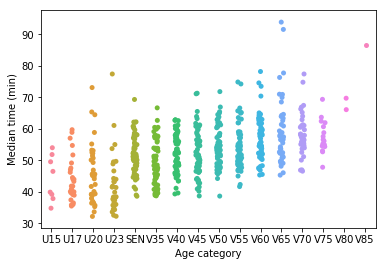

In [40]:
xorder = ['U15','U17','U20','U23','SEN','V35','V40','V45','V50','V55',
        'V60','V65','V70','V75','V80','V85']
ax=plt.gca()
sns.stripplot(dftimes['age_group'], dftimes['min_time'], 
              order=xorder,jitter=True)
ax.set_xlabel('Age category')
ax.set_ylabel('Median time (min)')
plt.show()

In [44]:
df_sen = dfnew.loc[(dfnew['age_group']=='SEN') & (dfnew['sex']=='W')]

In [45]:
time_up=df_sen.groupby(['meeting_id','diff','sum_up','sum_down'],as_index=False)['min_time'].mean()

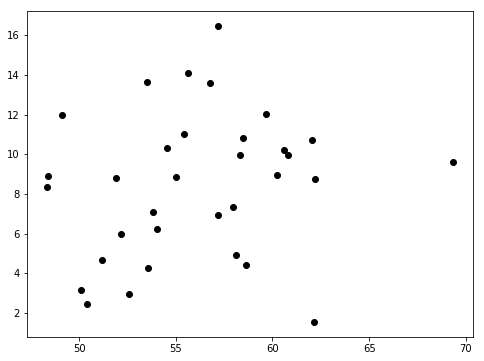

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax = plt.gca()
axes.scatter(time_up['min_time'], time_up['sum_up'], color='black')

In [48]:
Y = []
for index,row in dfnew.iterrows():
    sex  = row.sex
    age  = row.age_group
    time = row.min_time 
    ID   = row.meeting_id
    temp = dftimes.loc[(dftimes['age_group']==age) & 
                          (dftimes['sex']==sex) &
                          (dftimes['meeting_id'] == ID)]
    avg_time = (temp.min_time).item()
    #print(avg_time.item(), sex, age, time, ID)
    Y.append(0 if (time<=avg_time) else 1)
    #Y.append(time-avg_time)

In [49]:
X = dfnew
X = X.drop(['position','meeting_id'], axis=1)

In [50]:
age_map = {'U15':0,'U17':0,'U20':0,'U23':0,'SEN':1,'V35':2,'V40':3,
           'V45':3,'V50':4,'V55':4,'V60':5,'V65':5,
           'V70':6,'V75':6,'V80':7,'V85':7}
for xrow in [X]:
    xrow['sex'] = xrow['sex'].map( {'W': 1, 'M': 0} ).astype(int)
    xrow['age_group'] = xrow['age_group'].map( age_map )

In [51]:
clf = LogisticRegression()
clf.fit(X, Y)

/home/freddy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## This is what I get when I use y=1 and 0
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logreg.coef_))], axis = 1)
print(coefficients)
           0         0
0  age_group -0.432731
1        sex  2.718308
2   min_time  0.315732
3     sum_up  0.053070
4   sum_down -0.114251
5       diff  0.167322


In [52]:
beta = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
print(beta)

           0         0
0  age_group -0.488673
1        sex -2.983713
2   min_time  0.353489
3     sum_up  0.232592
4   sum_down  0.259905
5      sigma -0.006086
6       mean  0.012074
7       diff -0.027313


In [53]:
d = []
for index, row in X.iterrows():
    rowidx=0
    for i in row:
        #print(i,beta.values[rowidx][1])
        dtemp = i*beta.values[rowidx][1]
        rowidx+=1
        d.append(dtemp)

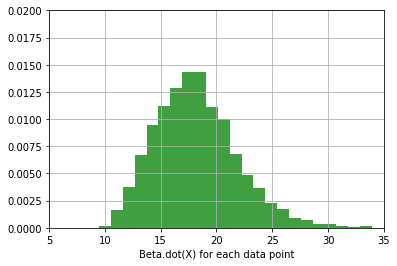

In [61]:
n, bins, patches = plt.hist(d, 50, density=True, 
                            facecolor='g', alpha=0.75)
plt.axis([5, 35, 0, 0.02])
plt.grid(True)
plt.xlabel('Beta.dot(X) for each data point')
plt.show()